In [1]:
import pandas as pd 
import seaborn as sns
import geohash
import matplotlib.pyplot as plt
from math import radians, cos, sin, asin, sqrt
%matplotlib inline
train = pd.read_csv("train.csv",sep = ',',parse_dates=['starttime'])
# test = pd.read_csv("test.csv",sep = ',',parse_dates=['starttime'])

In [2]:
train.head()

orderid   userid  bikeid  biketype           starttime geohashed_start_loc  \
0  1893973   451147  210617         2 2017-05-14 22:16:50             wx4snhx   
1  4657992  1061133  465394         1 2017-05-14 22:16:52             wx4dr59   
2  2965085   549189  310572         1 2017-05-14 22:16:51             wx4fgur   
3  4548579   489720  456688         1 2017-05-14 22:16:51             wx4d5r5   
4  3936364   467449  403224         1 2017-05-14 22:16:50             wx4g27p   

  geohashed_end_loc  
0           wx4snhj  
1           wx4dquz  
2           wx4fu5n  
3           wx4d5r4  
4           wx4g266

In [3]:
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

In [4]:
def _processData(df):
    # Time 处理时间序列数据
    df['weekday'] = df['starttime'].apply(lambda s : s.weekday()) # Monday is 0 and Sunday is 6
    df['hour'] = df['starttime'].apply(lambda s : s.hour)
    df['day'] = df['starttime'].apply(lambda s : str(s)[:10])
    print("Time process successfully!!!")
    
    # Geohash 将geohash代码转成经纬度（lat维度，lng经度）
    df['start_lat_lng'] = df['geohashed_start_loc'].apply(lambda s : geohash.decode(s))    # 开始位置
    df['end_lat_lng'] = df['geohashed_end_loc'].apply(lambda s : geohash.decode(s))        # 结束位置
    df['start_neighbors'] =  df['geohashed_start_loc'].apply(lambda s : geohash.neighbors(s))#获取开始位置的周边位置
    
    # geohashed降低成6位代码，精度降低
    df['geohashed_start_loc_6'] = df['geohashed_start_loc'].apply(lambda s : s[:6])  
    df['geohashed_end_loc_6'] = df['geohashed_end_loc'].apply(lambda s : s[:6])
    df['start_neighbors_6'] =  df['geohashed_start_loc_6'].apply(lambda s : geohash.neighbors(s))
    
    #当6位geohash编码时的起点终点的经纬度数据
    train['start_lat_lng_6'] = train['geohashed_start_loc_6'].apply(lambda s : geohash.decode(s))    # 开始位置
    train['end_lat_lng_6'] = train['geohashed_end_loc_6'].apply(lambda s : geohash.decode(s))        # 结束位置
    train['start_neighbors_6'] =  train['geohashed_start_loc_6'].apply(lambda s : geohash.neighbors(s))#获取开始位置的周边位置

    print("Geohash process successfully!!!")

    # 判断目的地是否在neighbors
    def inGeohash(start_geohash,end_geohash,names):
        names.append(start_geohash)  #定义一个names，将开始区域和周边区域放进去
        if end_geohash in names:     #如果结束区域在names中，返回1，否则返回0
            return 1
        else:
            return 0 
    # 用df.apply(lambda)调用函数，返回一个df新列
    df['inside'] = df.apply(lambda s :inGeohash(s['geohashed_start_loc'],
                                                s['geohashed_end_loc'],
                                                s['start_neighbors'])
                            ,axis = 1)
    df['inside_6'] = df.apply(lambda s :inGeohash(s['geohashed_start_loc_6'],
                                                  s['geohashed_end_loc_6'],
                                                  s['start_neighbors_6'])
                              ,axis = 1)
    print("Geohash inside process successfully!!!")

    # Distance start -> end  计算开始到结束位置的距离
    def haversine(lon1, lat1, lon2, lat2): 
        """
        Calculate the great circle distance between two points 
        on the earth (specified in decimal degrees)
        """
        #计算两点间距离
        lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
        # haversine公式
        dlon = lon2 - lon1 
        dlat = lat2 - lat1 
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        c = 2 * asin(sqrt(a)) 
        r = 6371 # 地球平均半径，单位为公里
        return c * r * 1000
    df["start_end_distance"] = df.apply(lambda s : haversine(s['start_lat_lng'][1],
                                                             s['start_lat_lng'][0],
                                                             s['end_lat_lng'][1],
                                                             s['end_lat_lng'][0])
                                        ,axis = 1)
    print("Distance process successfully!!!")
    return df


In [5]:
train = _processData(train)

Time process successfully!!!
Geohash process successfully!!!
Geohash inside process successfully!!!
Distance process successfully!!!


In [6]:
train[["day","weekday","hour","start_lat_lng","end_lat_lng","start_end_distance"]].head()

day  weekday  hour                            start_lat_lng  \
0  2017-05-14        6    22  (40.10353088378906, 116.28959655761719)   
1  2017-05-14        6    22  (39.79042053222656, 116.32530212402344)   
2  2017-05-14        6    22  (39.88243103027344, 116.54228210449219)   
3  2017-05-14        6    22  (39.76570129394531, 116.16325378417969)   
4  2017-05-14        6    22  (39.96345520019531, 116.38847351074219)   

                               end_lat_lng  start_end_distance  
0  (40.10078430175781, 116.28684997558594)          384.504518  
1  (39.79728698730469, 116.32255554199219)          798.761617  
2  (39.87556457519531, 116.55189514160156)         1120.638699  
3  (39.76570129394531, 116.16188049316406)          117.377687  
4  (39.95933532714844, 116.38160705566406)          743.197624

In [7]:
# train.head(2) #测试用

In [8]:
# 测试用
# g_weekday = train.groupby("weekday")["orderid"].count()
# pd.DataFrame(g_weekday.values,index=[6,5,4,3,2,1,0])
# pd.DataFrame(g_weekday)

**各时间段用车量的分布**

In [32]:
def _timeAnalysis(df):
    # Days
    print("数据集包含的天数如下：")
    print(df['day'].unique())
    print("="*80)
    # 用户出行小时高峰期
    print("用户出行小时高峰期")
    g_hours = df.groupby("hour")['orderid'].count()
    print(g_hours.sort_values(ascending =False))
    # print(pd.DataFrame(g_hours.values,columns=["用车数量"]))
    plt.rc('figure',figsize=(10,6))
    # sns.set(style='whitegrid')
    sns.barplot(x=g_hours.index, y=g_hours.values)
    plt.show()
    
    print("="*80)
    # 周一 至 周日 用车分析, 按weekday分组，计算每weekday的订单
    print("周一~周日 各日用车数量")
    g_weekday = df.groupby("weekday")["orderid"].count() 
    #计数，这里不能用平均值，因为orderid是一个订单号，不是一个数值

    g_weekday_ = pd.DataFrame(g_weekday.values,index=["周一","周二","周三","周四","周五","周六","周日"],
                              columns=["订单数"])
    print(g_weekday_) 
    sns.barplot(x=g_weekday_.index,y=g_weekday_["订单数"],data=g_weekday_)
    # 或者
    # sns.barplot(x=["周一","周二","周三","周四","周五","周六","周日"],y=g_weekday.values)
    plt.show()
    print("="*80)
    
    # 周一 至 周日 不同时间的用车
    print("周一~周日 不同时间的用车")
    # 将周六日设为1，工作日设为0
    df.loc[(df['weekday'] == 5) | (df['weekday'] == 6),"isWeekend"] = 1
    df.loc[~((df['weekday'] == 5) | (df['weekday'] == 6)),"isWeekend"] = 0
    g1 = df.groupby(["isWeekend",'hour'])
    gg = df.groupby(["isWeekend",'hour'])["orderid"].count()
    g_h_w = pd.DataFrame(gg).reset_index("isWeekend")
    sns.barplot(x=g_h_w.index,y="orderid",hue="isWeekend",data=g_h_w)
    plt.show()

    print("以上数据不正确，因为是工作日有多天，而周末只有两天，因此应该算除以周末/工作日天数后的平均数")
    print("="*80)
    print("="*80)
    
    # 计算工作日与周末的天数
    g2 = df.groupby(["day","weekday"])
    print("日期对应的周几：")
    for i,j in list(g2.groups.keys()):
        print(i,"----",j)
    #必须按day和weekday分组，每个day对应一个weekday，
    #这样下面for计算多少个weekday是才能正确显示多少个weekday
    #然后再求平均数
    count_weekend = 0 # 周末天数
    count_weekday = 0 # 工作日天数
    for i,j in list(g2.groups.keys()):
        #g2.groups.keys()是group的两列分组依据
        if j >= 5:
            count_weekend += 1
        else:
            count_weekday +=1
    print("周末天数：",count_weekend,"\n工作日天数：",count_weekday)
    print("="*80)    
    
    # print(g1['orderid'].count()) #这是groupby生成的对象的功能属性，选取某一列的计数
    # temp_df = pd.DataFrame(g1['orderid'].count())
    # print(temp_df[:])
    
    #按是否周末，小时分组后，转成pandas，重设index   
    temp_df = pd.DataFrame(g1['orderid'].count()).reset_index()
    '''
    # g1 = df.groupby(["isWeekend",'hour'])
    # g1['orderid'].count() 是从g1中选取orderid的计数并生成一列，前面用pd.DataFrame转化成df，
    #原来g1有index（‘isWeekend’及‘hours’），temp_df也会带一样的index,
    #然后重设index，就不会再以isWeekend和hour分组的形式出现

    print(type(temp_df))
    print(temp_df.head(5))
    print("="*80)
    '''
    
    '''
    temp_df.loc[temp_df['isWeekend'] == 0.0,'orderid'] = temp_df['orderid'] / count_weekday
    temp_df.loc[temp_df['isWeekend'] == 1.0,'orderid'] = temp_df['orderid'] / count_weekend
    #上面两行是选取isWeekend为1或0的orderid,将其值改为平均数
    temp_df.sort_values(["isWeekend","orderid"],ascending =False)
    print(temp_df.head(5))
    print("F"*60)
    '''
    print("周末与工作日各小时平均订单数")
    
    # 重新插入一列名为avg_orderid,
    # 将orderid的总数改为平均数赋值给其对应的isWeekend为1或0的行
    temp_df.loc[temp_df['isWeekend'] == 0.0,'avg_orderid'] = temp_df['orderid'] / count_weekday
    temp_df.loc[temp_df['isWeekend'] == 1.0,'avg_orderid'] = temp_df['orderid'] / count_weekend

    temp_df.sort_values(["isWeekend","avg_orderid"],ascending =False)
    print(temp_df.head())

    sns.barplot(x = 'hour',y ="avg_orderid" ,hue = "isWeekend",data = temp_df )
    plt.xlabel('时',fontsize=12) 
    plt.ylabel('平均订单数',fontsize=12)
    plt.axhline(temp_df.loc[temp_df["isWeekend"]== 1.0]["avg_orderid"].mean(),linewidth=0.5,color="darkorange",linestyle="dashed")
    plt.axhline(temp_df.loc[temp_df["isWeekend"]== 0.0]["avg_orderid"].mean(),linewidth=0.5,color="steelblue",linestyle="dashed")
    plt.show()
    print("="*80)     
    
    print("计算有多少周，再算平均每周几的订单数")
    print("周一~周日 平均各日用车数量")
    
    n = count_weekday/5  #按工作日总天数除以5得到周数

    g_weekday = df.groupby("weekday")["orderid"].count() 

    #g_weekday_ = pd.DataFrame(g_weekday.values/n,index=["周一","周二","周三","周四","周五","周六","周日"])
    #print(g_weekday_)    
    #sns.barplot(x=g_weekday_.index,y=g_weekday_[0],data=g_weekday_)
    # 或者
    sns.barplot(x=["周一","周二","周三","周四","周五","周六","周日"],y=g_weekday.values/n,hue=None)
    plt.show()
    print("="*80)    

    # More plots...
    

数据集包含的天数如下：
['2017-05-14' '2017-05-15' '2017-05-16' '2017-05-12' '2017-05-13'
 '2017-05-10' '2017-05-11' '2017-05-18' '2017-05-19' '2017-05-23'
 '2017-05-24' '2017-05-20' '2017-05-22' '2017-05-21']
用户出行小时高峰期
hour
7     316142
18    290294
8     285078
17    273240
19    209194
12    199831
16    179272
11    172365
13    163768
15    155011
20    151748
9     148047
14    136380
21    127221
10    126796
6     121711
22     69905
5      29082
23     28489
0      13306
1       6216
4       4397
2       3714
3       2889
Name: orderid, dtype: int64


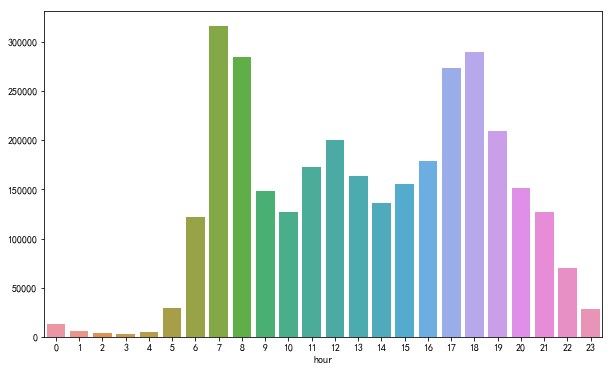

周一~周日 各日用车数量
       订单数
周一  404370
周二  439175
周三  390977
周四  594411
周五  579689
周六  359440
周日  446034


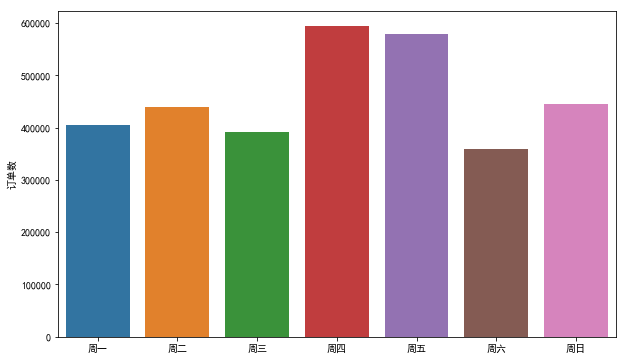

周一~周日 不同时间的用车


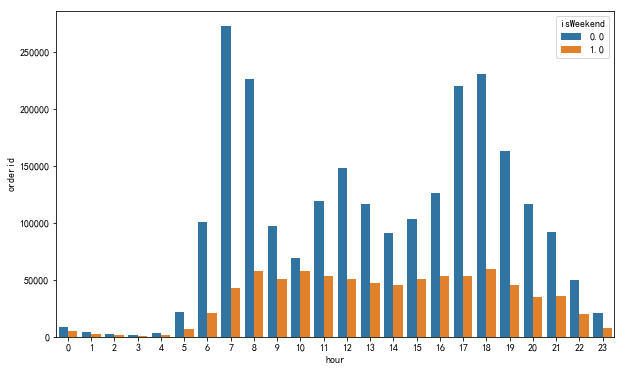

以上数据不正确，因为是工作日有多天，而周末只有两天，因此应该算除以周末/工作日天数后的平均数
日期对应的周几：
2017-05-10 ---- 2
2017-05-11 ---- 3
2017-05-12 ---- 4
2017-05-13 ---- 5
2017-05-14 ---- 6
2017-05-15 ---- 0
2017-05-16 ---- 1
2017-05-18 ---- 3
2017-05-19 ---- 4
2017-05-20 ---- 5
2017-05-21 ---- 6
2017-05-22 ---- 0
2017-05-23 ---- 1
2017-05-24 ---- 2
周末天数： 4 
工作日天数： 10
周末与工作日各小时平均订单数
   isWeekend  hour  orderid  avg_orderid
0        0.0     0     8512        851.2
1        0.0     1     3865        386.5
2        0.0     2     2420        242.0
3        0.0     3     1915        191.5
4        0.0     4     3089        308.9


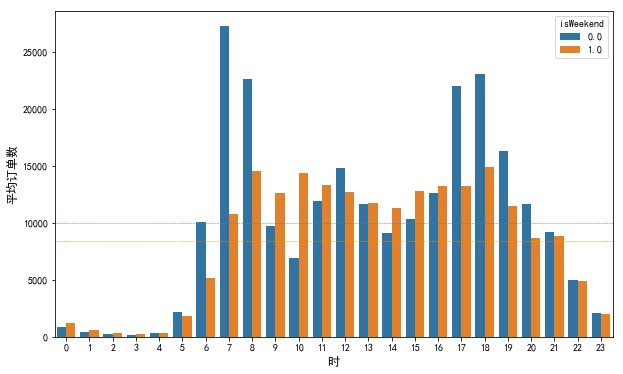

计算有多少周，再算平均每周几的订单数
周一~周日 平均各日用车数量


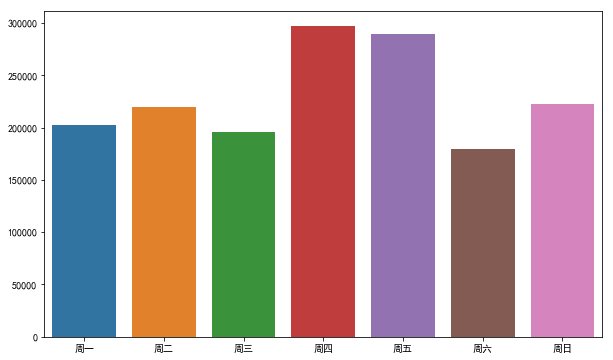

In [33]:
_timeAnalysis(train)

** 4公里内 骑行距离的分布情况 **

In [34]:
def Dist_Anl(df):

    # 周一到周五的骑行距离
    distance15 = df.start_end_distance[(train.start_end_distance<4000) & 
                                         (train.weekday<=4)]
    distance15.name = "Weekdays"
    # 周六日的骑行距离
    distance67 = df.start_end_distance[(train.start_end_distance<4000) & 
                                         (train.weekday>4)]
    distance67.name = "Weekends"

    sns.distplot(distance15,bins=50,label="Weekdays")
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.xlabel("Weekdays",fontsize=12) 
    plt.show()
    
    sns.distplot(distance67,bins=50,label="Weekends")
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.xlabel("Weekends",fontsize=12) 
    plt.show()

    sns.kdeplot(distance15,shade=True)
    sns.kdeplot(distance67,shade=True)
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.xlabel("Weekdays vs Weekends",fontsize=12) 
    plt.show()
    # len(distance15)


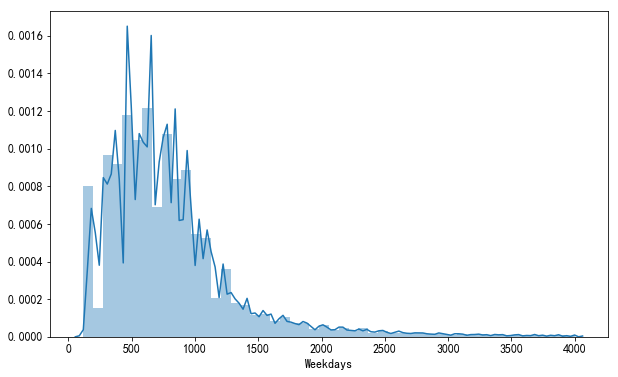

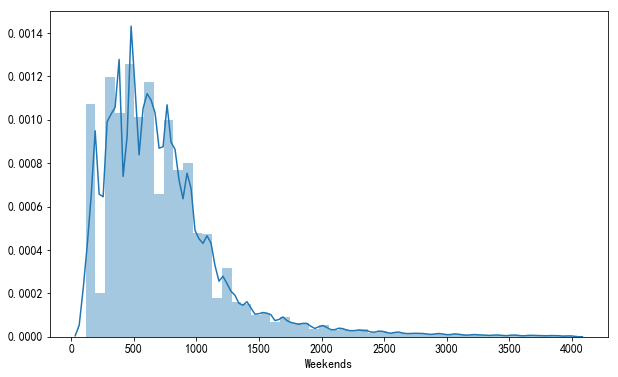

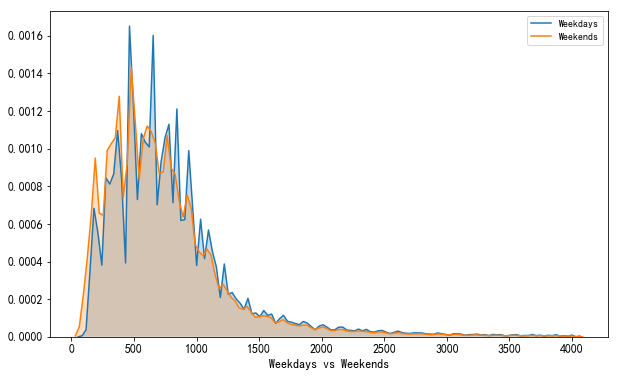

In [36]:
#设置不要显示warnings
import warnings
warnings.filterwarnings('ignore')
#调用函数
Dist_Anl(train)

In [50]:
# 计算周末及工作日各有多少
calc = train.groupby(["day","weekday"])
count_weekend = 0 # 周末天数
count_weekday = 0 # 工作日天数
for i,j in list(calc.groups.keys()):
    if j >= 5:
        count_weekend += 1
    else:
        count_weekday +=1

In [51]:
# 周一到周五的骑行距离
def ragne_distribution(train):
    # 添加判断是否在工作日的列
    train.loc[train["weekday"]<=4.0,'IsWeekday'] = "Weekday"
    train.loc[train["weekday"]>4.0,'IsWeekday'] = "Weekend"
    # train.loc[train["IsWeekday"]=="0"].head()
    # 选取距离列及工作日判断列
    distance = train.loc[(train.start_end_distance<3000)][["start_end_distance","IsWeekday"]]
    # distance.head()
    # 按距离分段并按是否工作日分组，统计每组数量
    labels = pd.cut(distance.start_end_distance,30)
    distance2 = distance.groupby(["IsWeekday",labels]).size()
    distance3 = distance2.unstack("IsWeekday")

    # 整理数据,取平均数
    distance3.Weekday = (distance3.Weekday/count_weekday).astype("int")
    distance3.Weekend = (distance3.Weekend/count_weekend).astype("int")
    distance3.index.name = "Range"
    #转成百分数
    dis_ = distance3.unstack().unstack("Range")
    nor_sum = dis_.div(dis_.sum(axis=1),axis = 0).unstack().unstack("IsWeekday")
    nor_sum

    #工作日与非工作日百分比
    dis_2 = distance3.div(distance3.sum(1),axis=0)
    dis_2

    # 画图
    %pylab inline
    pylab.rcParams['figure.figsize'] = (12, 8)
    print("工作日平均骑行距离分布")
    sns.barplot(x=distance3.index, y='Weekday',data=distance3)
    plt.xticks(range(-1,29),distance3.index.values,rotation=45)
    plt.show()
    print("非工作日平均骑行距离分布")
    sns.barplot(x=distance3.index, y='Weekend',data=distance3)
    plt.xticks(range(-1,29),distance3.index.values,rotation=45)
    plt.show()
    print("工作日与非工作日平均骑行距离分布对比")
    distance3.plot(kind="bar") # 或distance3.plot.bar()
    plt.xticks(range(-1,29),distance3.index.values,rotation=45)
    plt.show()
    print("工作日与非工作日平均骑行距离分布对比(占距离区间总分布的百分比)")
    nor_sum = dis_.div(dis_.sum(axis=1),axis = 0).unstack().unstack("IsWeekday")
    nor_sum.plot(kind="bar")
    plt.xticks(range(-1,29),distance3.index.values,rotation=45)
    plt.show()
    print("工作日与非工作日平均订单百分比对比（单一区间内工作日与非工作日的）")
    dis_2.plot(kind="bar",stacked=True)
    plt.xticks(range(-1,29),distance3.index.values,rotation=45)
    plt.axhline(0.5,color="R")
    plt.show()

Populating the interactive namespace from numpy and matplotlib
工作日平均骑行距离分布


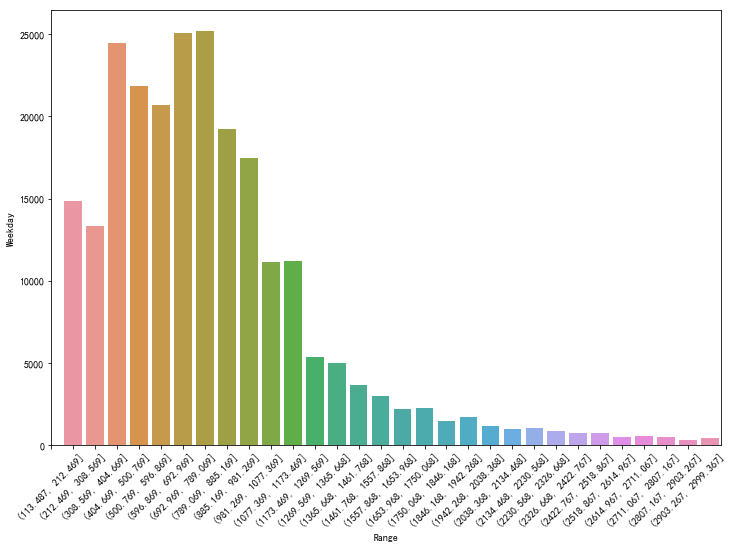

非工作日平均骑行距离分布


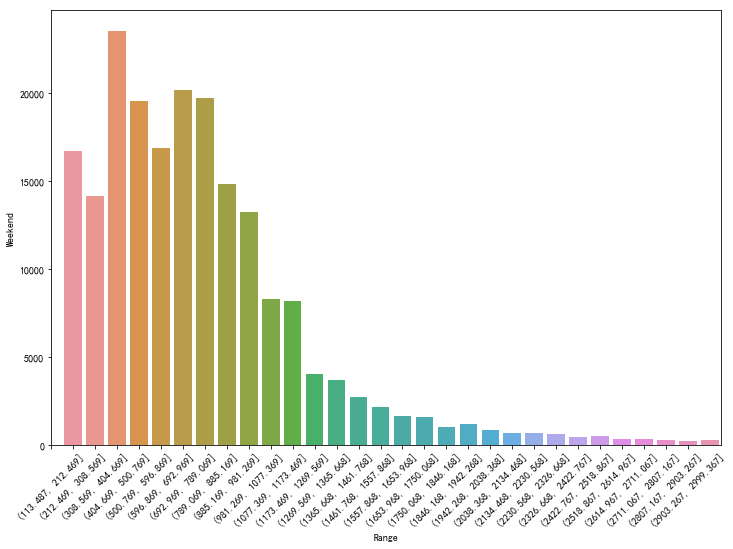

工作日与非工作日平均骑行距离分布对比


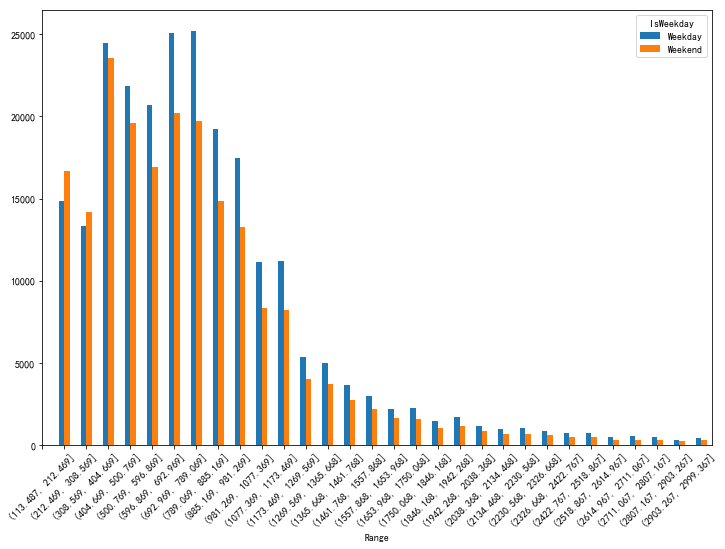

工作日与非工作日平均骑行距离分布对比(占距离区间总分布的百分比)


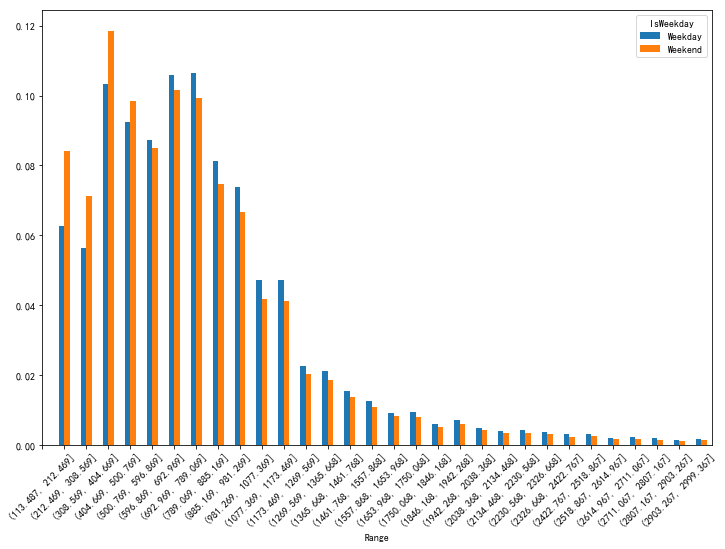

工作日与非工作日平均订单百分比对比（单一区间内工作日与非工作日的）


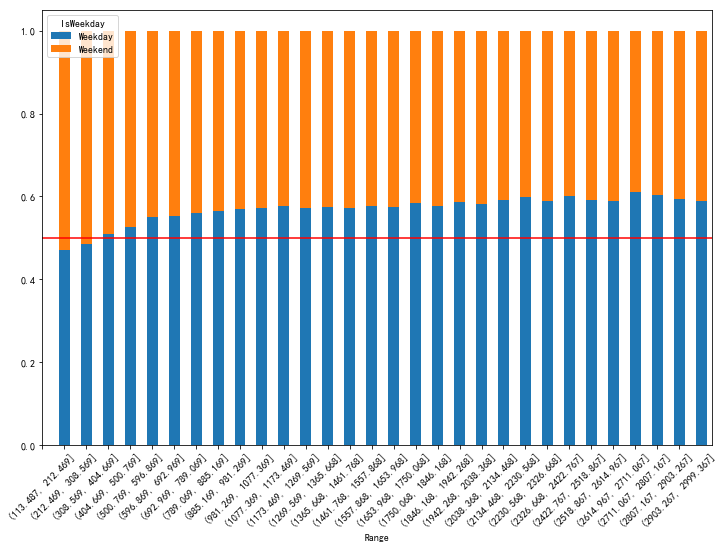

In [52]:
ragne_distribution(train)

** 用户喜欢的单车类型 **

    由于工作日用车数量多，并且主要分布在上下班高峰段，因此在分析用户喜欢哪种单车类型时，而在周日，用户不用上班，用车时段分布较均匀，没有工作日用车高峰导致的无选择性。因此，此处我们特地选取周日的数据

    另外，此处需要忽略一个重要的因素，就是不同单车类型的市场投放量不同，因此在这里的分析单单作为举例用就行了。

In [53]:
def bike_like(train):
    train_bl = train.loc[(train.start_end_distance<3000) & (train.weekday==6)][["biketype","orderid","hour","start_end_distance",]]
    labels = pd.cut(train_bl.start_end_distance,30)
    bike_like1 = train_bl.groupby(["biketype",labels]).size().unstack("biketype")
    bike_like1.rename(columns={1:"Type1",2:"Type2"},inplace=True)
    # 数量除以周数
    bike_like1["Type1"] = (bike_like1["Type1"]/count_weekend).astype("int")
    bike_like1["Type2"] = (bike_like1["Type2"]/count_weekend).astype("int")
    bike_like1

    print("周日不同单车类型骑行距离分布对比")
    bike_like1.plot(kind="bar") 
    plt.xticks(range(-1,29),bike_like1.index.values,rotation=60,size=12)
    plt.show()

    bike_like2 = train_bl.groupby(["hour","biketype"])["orderid"].count().unstack()
    bike_like2.rename(columns={1:"Type1",2:"Type2"},inplace=True)
    bike_like2["Type1"] = (bike_like2["Type1"]/count_weekend).astype("int")
    bike_like2["Type2"] = (bike_like2["Type2"]/count_weekend).astype("int")
    bike_like2

    print("周日不同单车类型各时段订单数分布对比")
    bike_like2.plot(kind="bar") 
    plt.xticks(range(0,24),bike_like2.index.values,rotation=30,size=12)
    plt.show()

周日不同单车类型骑行距离分布对比


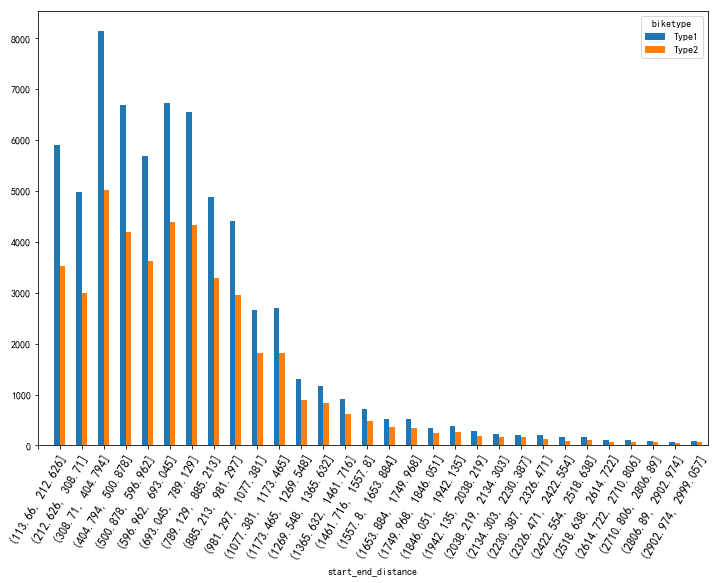

周日不同单车类型各时段订单数分布对比


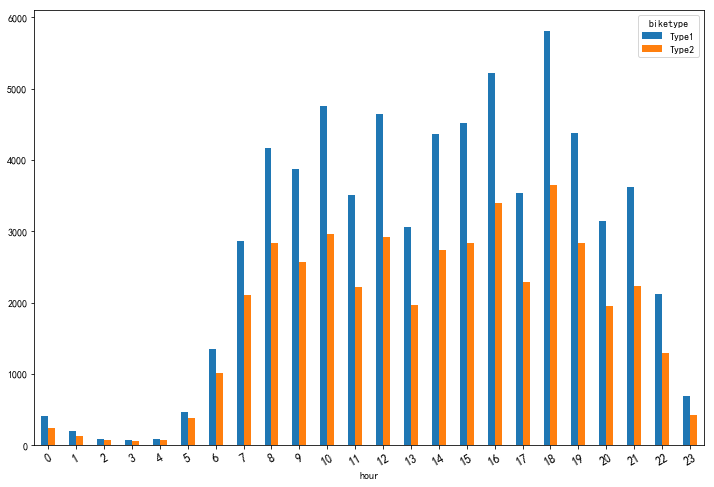

In [54]:
bike_like(train)

** 用车量集中区域的分析 **

In [169]:
aaa = train.loc[(train.start_end_distance<3000)& (train.isWeekend==0)][["orderid","start_lat_lng","end_lat_lng"]]
aaa["start_lat"] = aaa.start_lat_lng.apply(lambda x: x[0]).round(2)
aaa["start_lng"] = aaa.start_lat_lng.apply(lambda x: x[1]).round(2)
aaa["end_lat"] = aaa.end_lat_lng.apply(lambda x: x[0]).round(2)
aaa["end_lng"] = aaa.end_lat_lng.apply(lambda x: x[1]).round(2)
bbb = aaa.groupby(["start_lat","start_lng"])["orderid"].count().reset_index()

# 经纬度范围很大，但数据太过于集中在纬度40到41度，及经度116度，不断的缩小范围，就为了图好看点。。。。
ccc = bbb[(bbb["start_lat"]>=39.50) & 
          (bbb["start_lat"]<=41.50) & 
          (bbb["start_lng"]>=116.10)&
         (bbb["start_lng"]<=116.60)&(bbb["orderid"]>=500)]
ddd = ccc.set_index('start_lat').set_index('start_lng',append=True).unstack().fillna(0)
eee = pd.DataFrame(ddd.values,columns=ddd.columns.levels[1],index=ddd.index)

# print("用车区域分布")

# ccc.plot.scatter(x="start_lng",y="start_lat",c="orderid") #散点图
# # plt.xticks(arange(0,0.5),arange(116.1,116.6,0.1),size=12) #不起作用？？
# # plt.xlabel("start_lng") #不起作用？？ - 要用对象设置？plt.set_xticks() 
# plt.yticks(size=12)
# plt.axhline(39.85,color="G",linewidth=0.7)
# plt.axvline(116.4,color="G")
# plt.show()
# lat_lgst = ccc.start_lat[ccc.idxmax().orderid]
# lng_lgst = ccc.start_lng[ccc.idxmax().orderid]
# count_large = ccc.orderid.max()
# print("最大订单量的经纬度：", lng_lgst,"-",lat_lgst)
# print("最大订单量：",count_large)

In [202]:
lat_lgst = ccc.start_lat[ccc.idxmax().orderid]
lng_lgst = ccc.start_lng[ccc.idxmax().orderid]
count_large = ccc.orderid.max()
print("最大订单量的经纬度：", lng_lgst,"-",lat_lgst)
print("最大订单量：",count_large)
top10 = ccc.sort_values('orderid',ascending=False)[:10].reset_index().drop('index',axis=1)
top10.index.name="top10"
top10
# 或者用nlargest函数
# top_ten = ccc.nlargest(10,'orderid').reset_index().drop('index',axis=1)
# top_ten

最大订单量的经纬度： 116.4 - 39.85
最大订单量： 16516


start_lat  start_lng  orderid
top10                               
0          39.85     116.40    16516
1          39.85     116.43    11285
2          39.85     116.39    10648
3          39.85     116.37     9251
4          39.87     116.46     9175
5          39.92     116.48     9022
6          39.92     116.52     8824
7          39.85     116.41     8797
8          39.88     116.48     8526
9          39.98     116.31     8424

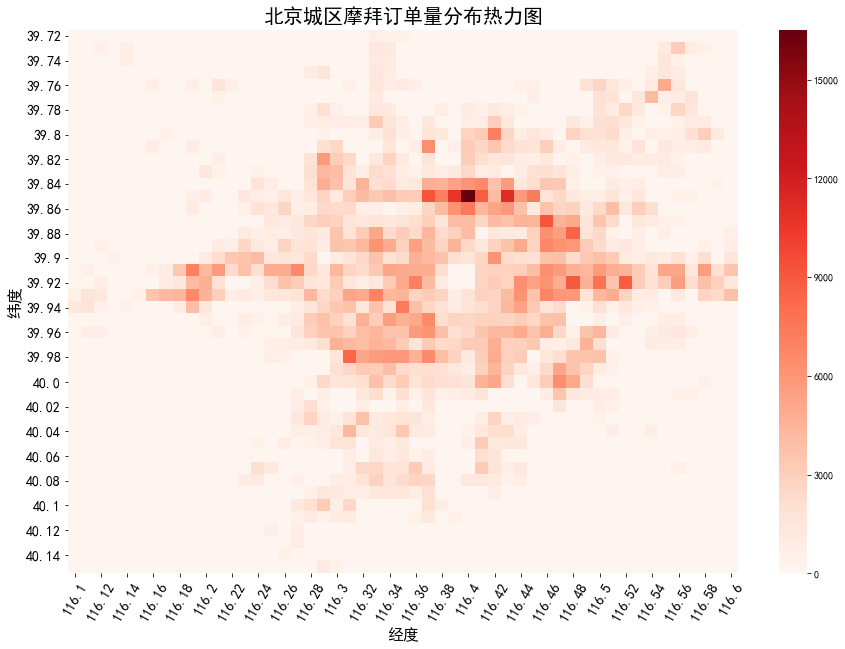

In [259]:
plt.rcParams['figure.figsize'] = (15, 10)
plt.xticks(size=14)
plt.yticks(size=14)

ax = sns.heatmap(eee,cmap="Reds")
ax.set_title('北京城区摩拜订单量分布热力图',fontsize=20)
ax.set_xlabel("经度",fontsize=16)   #或 plt.xlabel("经度",fontsize=18)
ax.set_ylabel("纬度",fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(),rotation=60)   #或 plt.xticks(rotation=60)
plt.show()